## Transfer Learning with TensorFlow Part 3: Scaling up (🍔👁 Food Vision mini)

### What we're going to cover
We're going to go through the follow with TensorFlow:

Downloading and preparing 10% of the Food101 data (10% of training data)
Training a feature extraction transfer learning model on 10% of the Food101 training data
Fine-tuning our feature extraction model
Saving and loaded our trained model
Evaluating the performance of our Food Vision model trained on 10% of the training data
Finding our model's most wrong predictions
Making predictions with our Food Vision model on custom images of food

In [1]:
!wget https://raw.githubusercontent.com/heebyyy/tensorflow_fundamentals/main/helper_functions.py

--2023-02-26 14:46:21--  https://raw.githubusercontent.com/heebyyy/tensorflow_fundamentals/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-26 14:46:21 (81.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [3]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2023-02-26 14:46:34--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.210.128, 173.194.217.128, 108.177.13.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.210.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   132MB/s    in 13s     

2023-02-26 14:46:47 (118 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [4]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/caprese_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hummus'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cup_cakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/frozen_yogurt'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/creme_brulee'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cheesecake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ceviche'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/french_onion_soup'.
There are 0 directories and 75 images in '101_f

In [5]:
import tensorflow as tf

IMAGE_SIZE = (224,224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir, image_size = IMAGE_SIZE, label_mode='categorical')
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, image_size = IMAGE_SIZE, label_mode='categorical', shuffle= False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train our model on 101 food classes (10% of data)

In [6]:
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor= 'val_accuracy', save_weights_only =True, save_best_only=True)

In [7]:
data_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomZoom(0.2),
], name = 'data_augumentataion')

In [10]:
base_model = tf.keras.applications.EfficientNetB0( include_top=False)

base_model.trainable = False

inputs = tf.keras.layers.Input(shape = (224,224,3), name = 'input_layer' )

x = data_aug(inputs)
x = base_model(x, training = False)
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_pool_layer')(x)
outputs = tf.keras.layers.Dense(len(train_data.class_names), activation = 'softmax', name = 'output_layer')(x)

model = tf.keras.Model(inputs, outputs)

In [11]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augumentataion (Sequen  (None, None, None, 3)    0         
 tial)                                                           
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pool_layer (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [14]:
from keras.api._v2.keras import callbacks
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

history_all_class = model.fit(train_data, epochs = 5, steps_per_epoch = len(train_data),
                              validation_data = test_data, validation_steps = int(0.15 * len(test_data)),
                              callbacks =[checkpoint_callback])

Epoch 1/5


237/237 [==============================] - 129s 466ms/step - loss: 3.3852 - accuracy: 0.2828 - val_loss: 2.5024 - val_accuracy: 0.4605
Epoch 2/5
237/237 [==============================] - 97s 407ms/step - loss: 2.2037 - accuracy: 0.4972 - val_loss: 2.0472 - val_accuracy: 0.5148
Epoch 3/5
237/237 [==============================] - 89s 374ms/step - loss: 1.8278 - accuracy: 0.5691 - val_loss: 1.8918 - val_accuracy: 0.5294
Epoch 4/5
237/237 [==============================] - 87s 366ms/step - loss: 1.5991 - accuracy: 0.6181 - val_loss: 1.7932 - val_accuracy: 0.5392
Epoch 5/5
237/237 [==============================] - 86s 362ms/step - loss: 1.4456 - accuracy: 0.6502 - val_loss: 1.7588 - val_accuracy: 0.5469


In [15]:
# Evaluate model 
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 62s 78ms/step - loss: 1.5753 - accuracy: 0.5839


[1.5753302574157715, 0.5838811993598938]

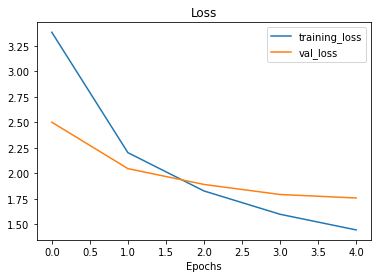

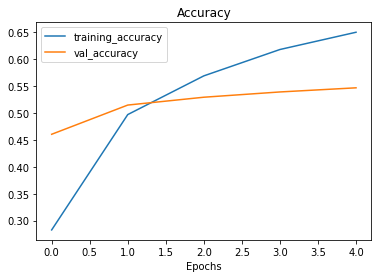

In [16]:
plot_loss_curves(history_all_class)

## Fine Tuning

In [20]:
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

In [23]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(0.0001),
              metrics = ['accuracy'])

In [24]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augumentataion True
efficientnetb0 True
global_average_pool_layer True
output_layer True


In [25]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number,  layer.name , layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [28]:
fine_tune_epochs = 10

history_all_class_fine_tune = model.fit(train_data, epochs = fine_tune_epochs, steps_per_epoch = len(train_data),
                                        validation_data = test_data, validation_steps = int(0.15*len(test_data)), 
                                        initial_epoch= history_all_class.epoch[-1])

Epoch 5/10


237/237 [==============================] - 96s 357ms/step - loss: 1.2179 - accuracy: 0.6834 - val_loss: 1.7725 - val_accuracy: 0.5371
Epoch 6/10
237/237 [==============================] - 81s 341ms/step - loss: 1.0792 - accuracy: 0.7135 - val_loss: 1.7543 - val_accuracy: 0.5453
Epoch 7/10
237/237 [==============================] - 78s 328ms/step - loss: 1.0117 - accuracy: 0.7302 - val_loss: 1.7185 - val_accuracy: 0.5493
Epoch 8/10
237/237 [==============================] - 79s 330ms/step - loss: 0.9518 - accuracy: 0.7406 - val_loss: 1.7426 - val_accuracy: 0.5453
Epoch 9/10
237/237 [==============================] - 78s 329ms/step - loss: 0.8884 - accuracy: 0.7613 - val_loss: 1.7468 - val_accuracy: 0.5469
Epoch 10/10
237/237 [==============================] - 75s 314ms/step - loss: 0.8344 - accuracy: 0.7787 - val_loss: 1.7600 - val_accuracy: 0.5469


In [29]:
# Evaluate fine-tuned model on the whole test dataset
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 59s 75ms/step - loss: 1.5149 - accuracy: 0.6002


[1.5149153470993042, 0.6001980304718018]

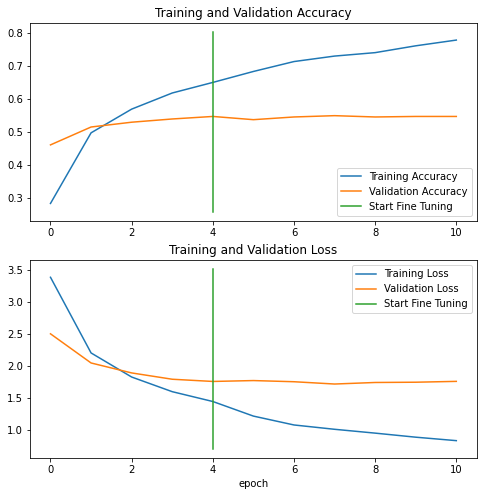

In [31]:
compare_historys(original_history=history_all_class,
                 new_history=history_all_class_fine_tune,
                 initial_epochs=5)
     

## Saving and Loading our Model

In [39]:
model.save('Drive/My Drive/tensorflow_developer/101_food_class_10_percent_saved_big_dog_model')

TypeError: ignored

In [36]:
# loaded_model = tf.keras.load_model('Drive/My Drive/tensorflow_developer/101_food_class_10_percent_saved_big_dog_model')

### Predictions

In [40]:
pred_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 65s 80ms/step


In [52]:
len(test_data)

790

In [53]:
len(pred_probs)

25250

In [54]:
pred_probs.shape

(25250, 101)

In [55]:
pred_probs[0]

array([3.8802865e-01, 1.1323350e-04, 1.5155692e-01, 4.6649500e-08,
       3.4870391e-06, 1.0283984e-06, 9.1869711e-05, 1.0959695e-06,
       2.1027224e-02, 1.4333302e-04, 9.7579129e-07, 3.8571802e-06,
       2.1997935e-04, 3.8126842e-07, 2.9678755e-03, 8.4471417e-04,
       1.1081470e-05, 6.2107196e-04, 5.1163635e-03, 1.5027126e-05,
       1.4078227e-03, 3.0799492e-06, 3.2870765e-04, 4.3647891e-04,
       7.7068567e-04, 1.4984165e-03, 3.2948697e-04, 3.8268990e-05,
       1.0014707e-01, 5.0439226e-04, 2.1127100e-06, 2.0025652e-03,
       3.9985965e-04, 4.8568194e-07, 6.4589987e-03, 1.9923079e-06,
       7.1378163e-05, 2.1486212e-03, 6.4556509e-02, 1.7036768e-05,
       5.7219760e-04, 2.1729101e-03, 3.9502105e-04, 1.2914436e-05,
       2.3905293e-05, 4.7824083e-06, 2.3142244e-03, 1.0675342e-04,
       4.4012231e-07, 5.2433752e-02, 8.2478255e-05, 1.1534219e-05,
       6.0515471e-02, 1.5798861e-02, 6.8766785e-06, 7.2805346e-03,
       1.0281848e-02, 1.4095907e-03, 2.1392978e-03, 2.7038253e

In [57]:
len(pred_probs[0])

101

In [58]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [3.8802865e-01 1.1323350e-04 1.5155692e-01 4.6649500e-08 3.4870391e-06
 1.0283984e-06 9.1869711e-05 1.0959695e-06 2.1027224e-02 1.4333302e-04
 9.7579129e-07 3.8571802e-06 2.1997935e-04 3.8126842e-07 2.9678755e-03
 8.4471417e-04 1.1081470e-05 6.2107196e-04 5.1163635e-03 1.5027126e-05
 1.4078227e-03 3.0799492e-06 3.2870765e-04 4.3647891e-04 7.7068567e-04
 1.4984165e-03 3.2948697e-04 3.8268990e-05 1.0014707e-01 5.0439226e-04
 2.1127100e-06 2.0025652e-03 3.9985965e-04 4.8568194e-07 6.4589987e-03
 1.9923079e-06 7.1378163e-05 2.1486212e-03 6.4556509e-02 1.7036768e-05
 5.7219760e-04 2.1729101e-03 3.9502105e-04 1.2914436e-05 2.3905293e-05
 4.7824083e-06 2.3142244e-03 1.0675342e-04 4.4012231e-07 5.2433752e-02
 8.2478255e-05 1.1534219e-05 6.0515471e-02 1.5798861e-02 6.8766785e-06
 7.2805346e-03 1.0281848e-02 1.4095907e-03 2.1392978e-03 2.7038253e-05
 4.2306053e-07 2.1308863e-03 1.7586965e-02 6.

In [60]:
pred_classes = pred_probs.argmax(axis =1)
pred_classes[:10]

array([ 0,  0,  0,  0,  8, 78, 29,  0,  2,  0])

In [61]:
len(pred_classes)

25250

In [62]:
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [63]:
len(y_labels)

25250

### Evaluating our model prediction

In [65]:
from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6001980198019802

In [66]:
from helper_functions import make_confusion_matrix

import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix


# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [68]:
class_names = test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

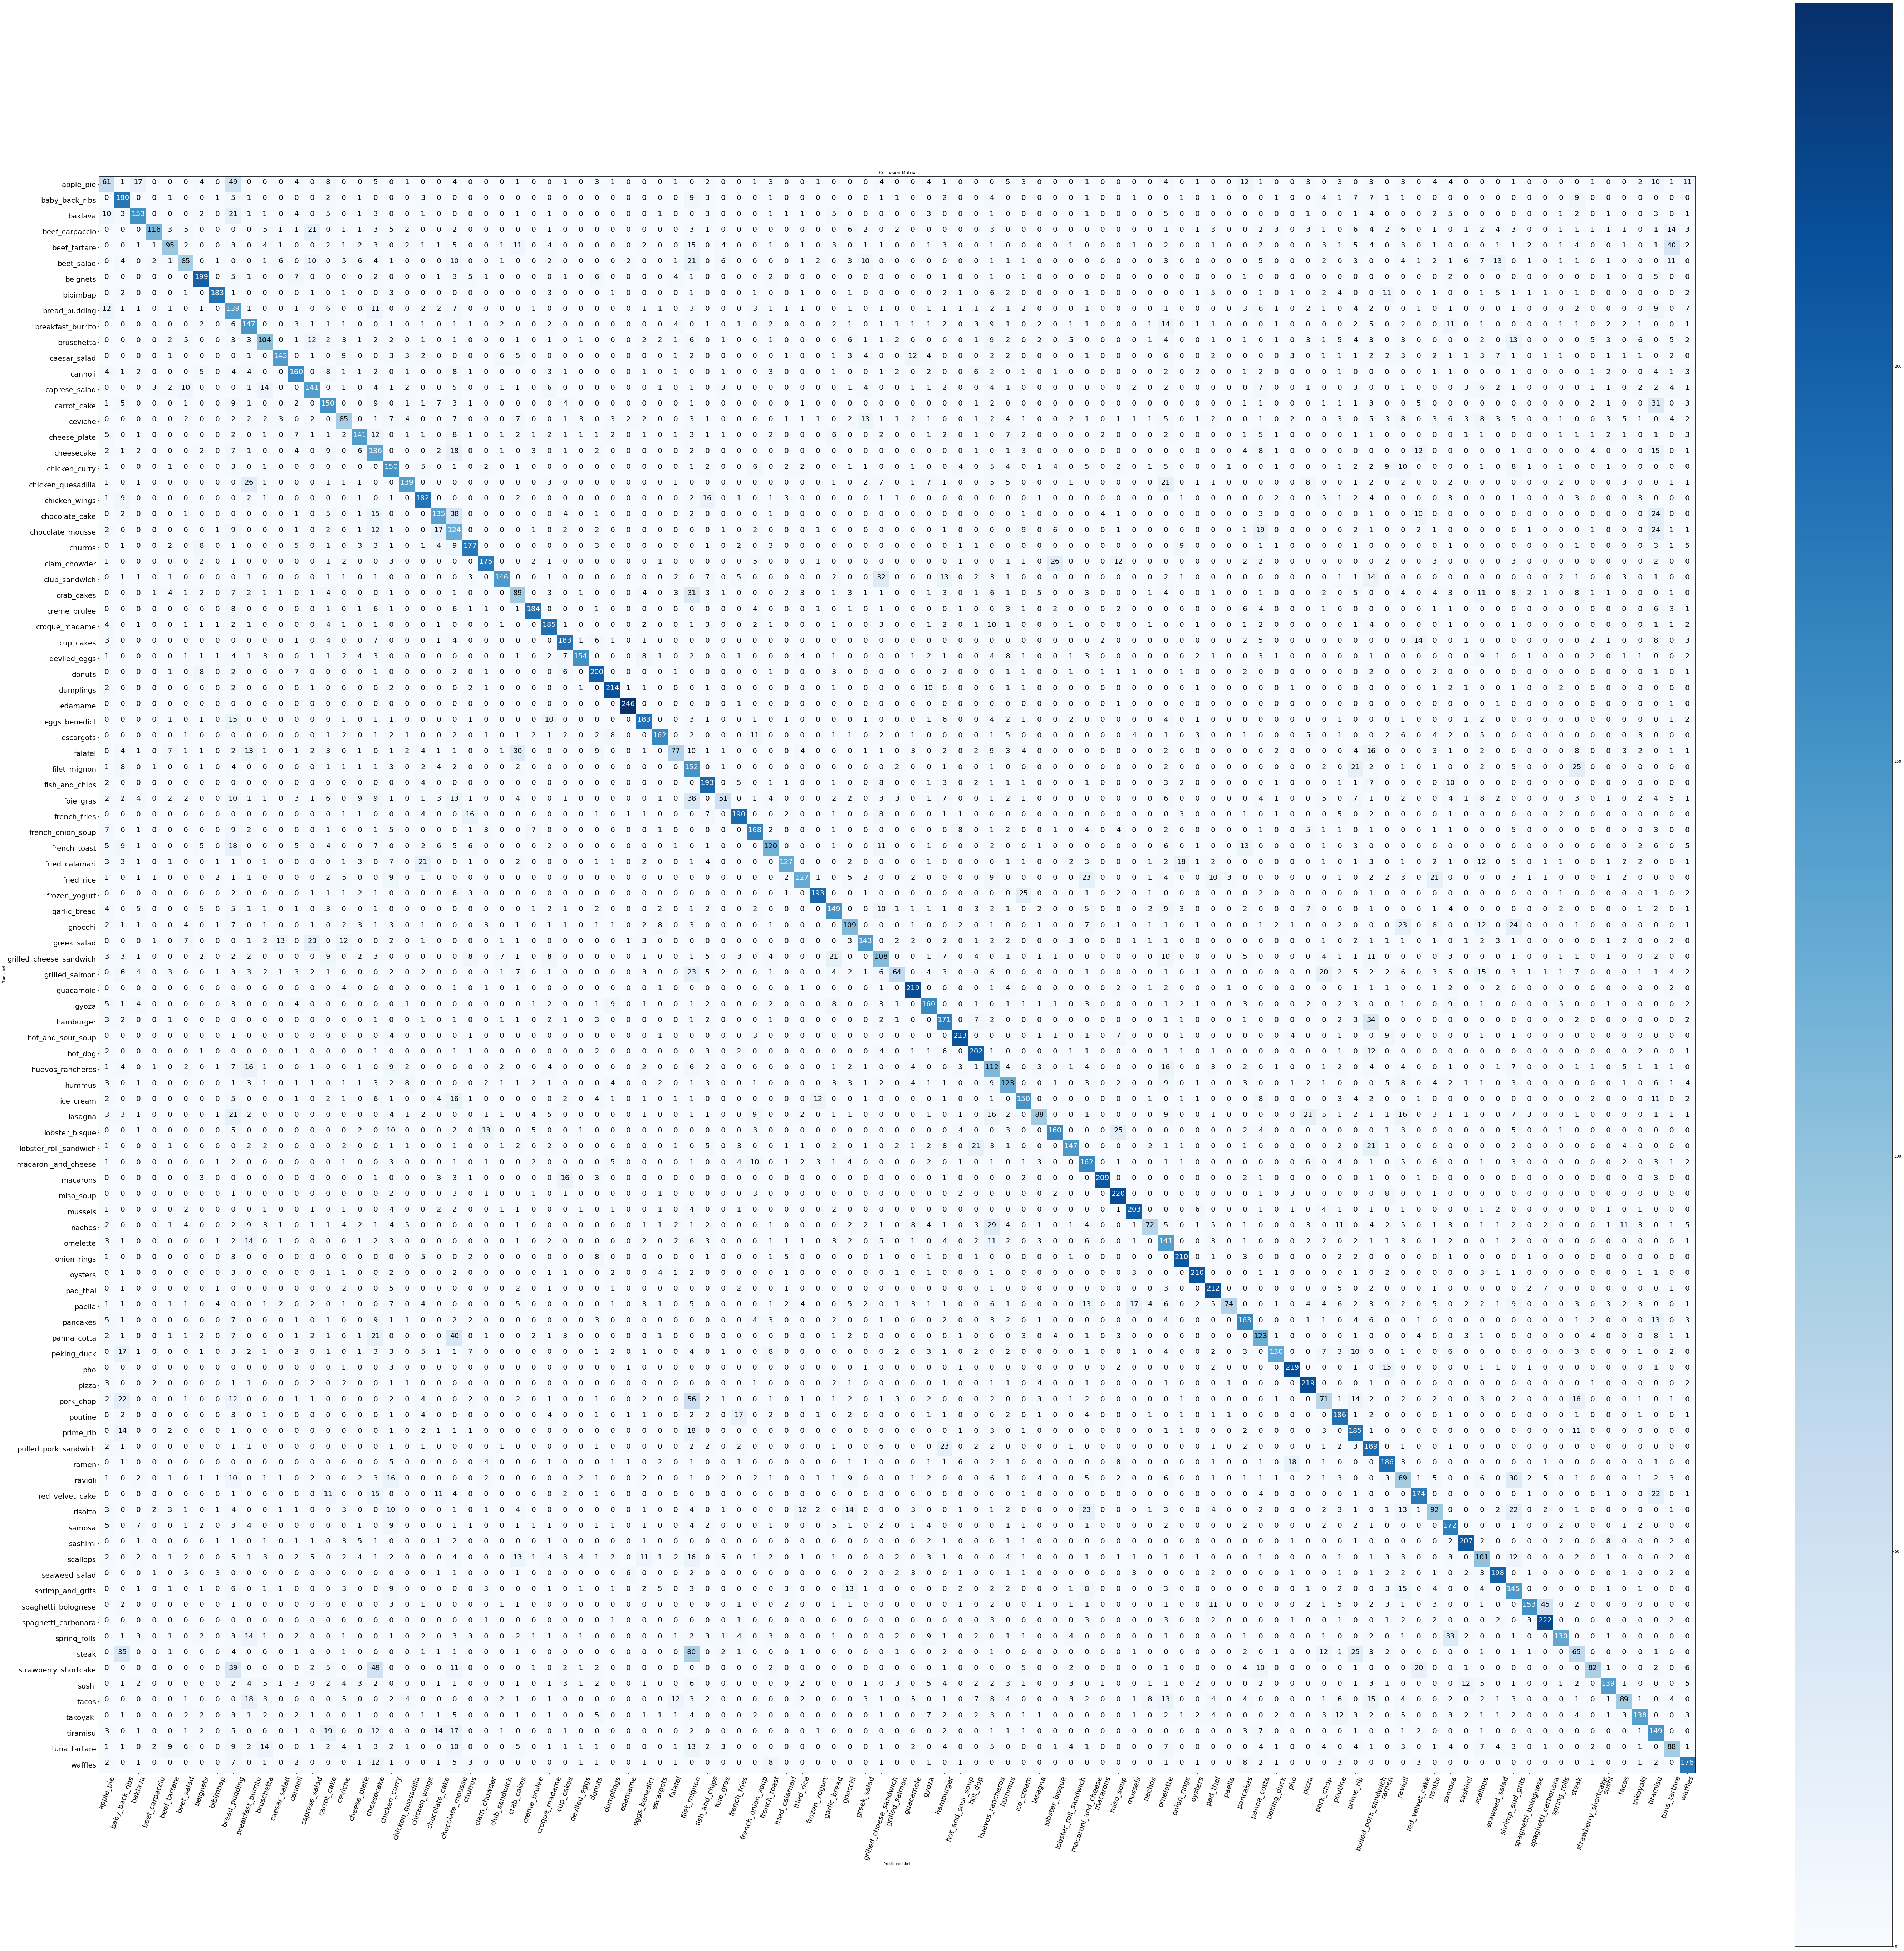

In [69]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [70]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.30      0.24      0.27       250
           1       0.50      0.72      0.59       250
           2       0.67      0.61      0.64       250
           3       0.87      0.46      0.60       250
           4       0.62      0.38      0.47       250
           5       0.53      0.34      0.41       250
           6       0.74      0.80      0.77       250
           7       0.88      0.73      0.80       250
           8       0.24      0.56      0.34       250
           9       0.47      0.59      0.52       250
          10       0.54      0.42      0.47       250
          11       0.81      0.57      0.67       250
          12       0.64      0.64      0.64       250
          13       0.57      0.56      0.57       250
          14       0.51      0.60      0.55       250
          15       0.45      0.34      0.39       250
          16       0.64      0.56      0.60       250
          17       0.33    

In [71]:
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.3034825870646766,
  'recall': 0.244,
  'f1-score': 0.27050997782705094,
  'support': 250},
 '1': {'precision': 0.4986149584487535,
  'recall': 0.72,
  'f1-score': 0.5891980360065467,
  'support': 250},
 '2': {'precision': 0.6710526315789473,
  'recall': 0.612,
  'f1-score': 0.6401673640167364,
  'support': 250},
 '3': {'precision': 0.8656716417910447,
  'recall': 0.464,
  'f1-score': 0.6041666666666666,
  'support': 250},
 '4': {'precision': 0.6209150326797386,
  'recall': 0.38,
  'f1-score': 0.47146401985111663,
  'support': 250},
 '5': {'precision': 0.53125,
  'recall': 0.34,
  'f1-score': 0.4146341463414634,
  'support': 250},
 '6': {'precision': 0.7397769516728625,
  'recall': 0.796,
  'f1-score': 0.7668593448940271,
  'support': 250},
 '7': {'precision': 0.8798076923076923,
  'recall': 0.732,
  'f1-score': 0.7991266375545851,
  'support': 250},
 '8': {'precision': 0.24471830985915494,
  'recall': 0.556,
  'f1-score': 0.33985330073349634,
  'support': 250},
 '

In [72]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.27050997782705094,
 'baby_back_ribs': 0.5891980360065467,
 'baklava': 0.6401673640167364,
 'beef_carpaccio': 0.6041666666666666,
 'beef_tartare': 0.47146401985111663,
 'beet_salad': 0.4146341463414634,
 'beignets': 0.7668593448940271,
 'bibimbap': 0.7991266375545851,
 'bread_pudding': 0.33985330073349634,
 'breakfast_burrito': 0.5203539823008849,
 'bruschetta': 0.4716553287981859,
 'caesar_salad': 0.6697892271662763,
 'cannoli': 0.6412825651302605,
 'caprese_salad': 0.5685483870967741,
 'carrot_cake': 0.5484460694698354,
 'ceviche': 0.38636363636363635,
 'cheese_plate': 0.5987261146496814,
 'cheesecake': 0.407185628742515,
 'chicken_curry': 0.4975124378109453,
 'chicken_quesadilla': 0.6405529953917051,
 'chicken_wings': 0.6907020872865275,
 'chocolate_cake': 0.5660377358490566,
 'chocolate_mousse': 0.35890014471780024,
 'churros': 0.7023809523809524,
 'clam_chowder': 0.7462686567164178,
 'club_sandwich': 0.675925925925926,
 'crab_cakes': 0.3787234042553192,
 'creme_brul

In [73]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

class_name  f1-score
33            edamame  0.960938
63           macarons  0.891258
75                pho  0.863905
69            oysters  0.843373
54  hot_and_sour_soup  0.836935
..                ...       ...
82            ravioli  0.330855
77          pork_chop  0.324943
39          foie_gras  0.300885
93              steak  0.289532
0           apple_pie  0.270510

[101 rows x 2 columns]

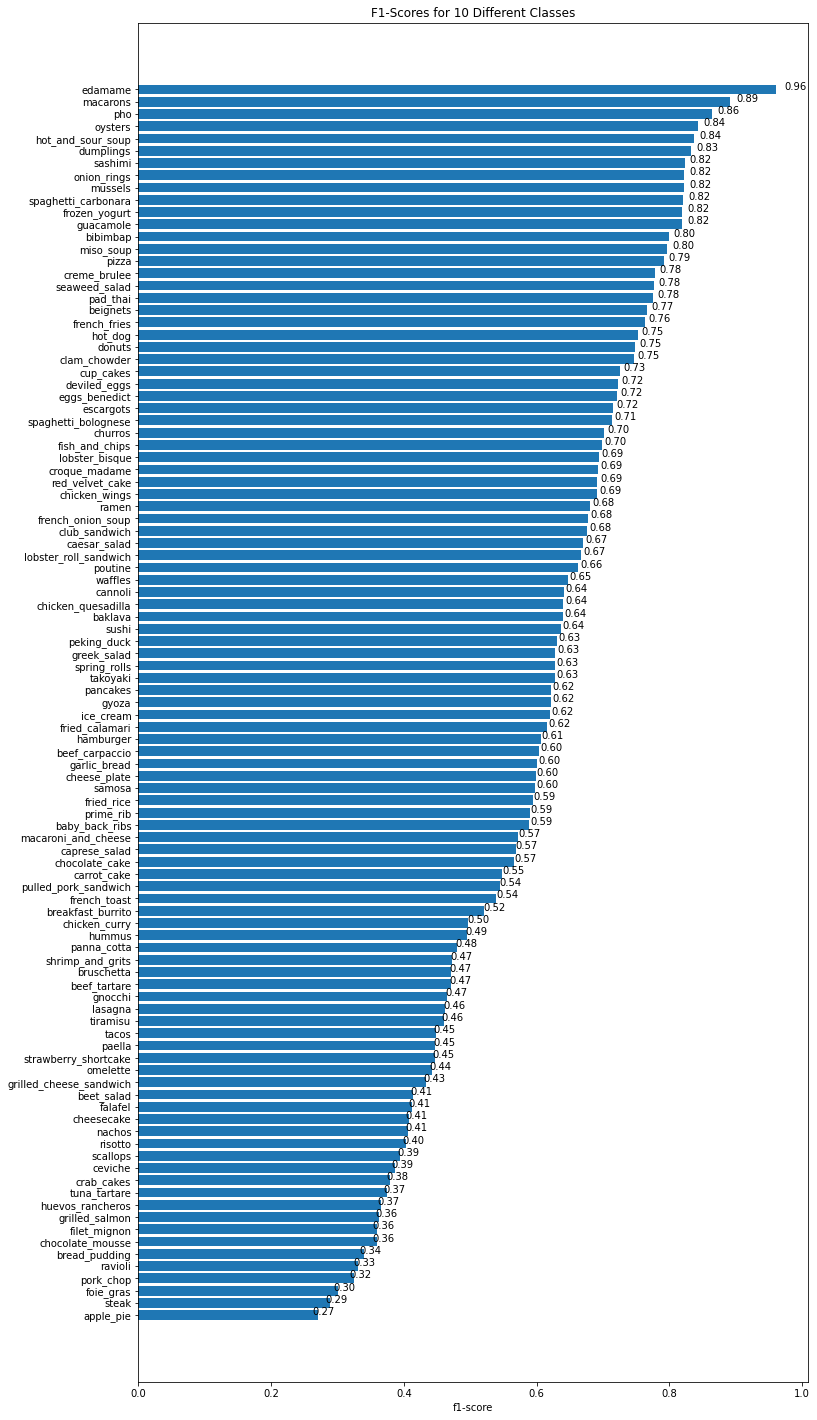

In [76]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

## Visualizing and predictions on test images

In [77]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

1/1 [==============================] - 0s 32ms/step


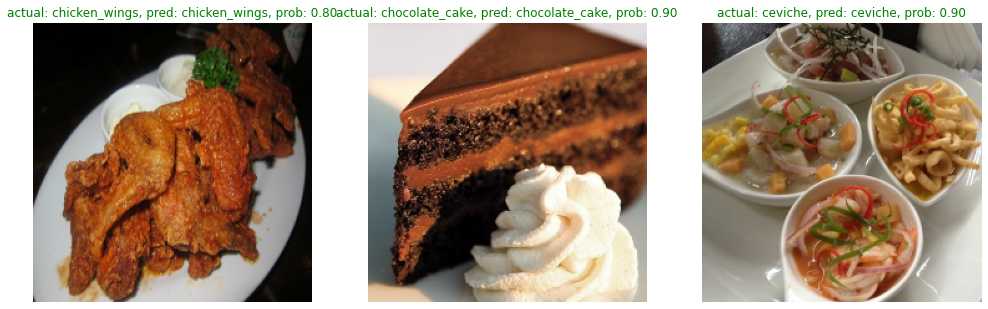

In [83]:
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

## Finding the most wrong prediction

In [84]:
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", 
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [85]:
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

   pred_conf y_true_classname y_pred_classname  
0   0.388029        apple_pie        apple_pie  
1   0.916380        apple_pie        apple_pie  
2   0.532525        apple_pie        apple_pie  
3   0.209342        apple_pie        apple_pie  
4   0.522382        apple_pie    bread_pudding

In [86]:
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.388029        apple_pie        apple_pie          True  
1   0.916380        apple_pie        apple_pie          True  
2   0.532525        apple_pie        apple_pie          True  
3   0.209342        apple_pie        apple_pie          True  
4   0.522382        apple_pie    bread_pudding         False

In [87]:
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
23797  b'101_food_classes_10_percent/test/sushi/16593...      95      86   
17855  b'101_food_classes_10_percent/test/paella/2314...      71      65   
21810  b'101_food_classes_10_percent/test/scallops/17...      87      29   
11642  b'101_food_classes_10_percent/test/garlic_brea...      46      10   
11024  b'101_food_classes_10_percent/test/fried_rice/...      44      70   
18001  b'101_food_classes_10_percent/test/pancakes/10...      72      67   
191    b'101_food_classes_10_percent/test/apple_pie/3...       0      31   
5114   b'101_food_classes_10_percent/test/chicken_win...      20      38   
9110   b'101_food_classes_10_percent/test/falafel/241...      36      31   
7295   b'101_food_classes_10_percent/test/cup_cakes/1...      29      31   
15142  b'101_food_classes_10_percent/test/lobster_bis...      60      64   
16271  b'101_food_classes_10_percent/test/mussels/140...      65      69   
10847  b'101_food_classes_10_percent/test/fried_calam...      43      68   
17897  b'101_food_classes_10_percent/test/paella/2986...      71      65   
11097  b'101_food_classes_10_percent/test/fried_rice/...      44      70   
8794   b'101_food_classes_10_percent/test/escargots/1...      35      41   
23631  b'101_food_classes_10_percent/test/strawberry_...      94      83   
15826  b'101_food_classes_10_percent/test/macarons/19...      63      29   
10880  b'101_food_classes_10_percent/test/fried_calam...      43      68   
20214  b'101_food_classes_10_percent/test/pulled_pork...      80      53   

       pred_conf      y_true_classname   y_pred_classname  pred_correct  
23797   0.998320                 sushi            sashimi         False  
17855   0.997627                paella            mussels         False  
21810   0.997413              scallops          cup_cakes         False  
11642   0.997063          garlic_bread         bruschetta         False  
11024   0.996390            fried_rice           pad_thai         False  
18001   0.996314              pancakes           omelette         False  
191     0.996049             apple_pie             donuts         False  
5114    0.996045         chicken_wings     fish_and_chips         False  
9110    0.995979               falafel             donuts         False  
7295    0.995605             cup_cakes             donuts         False  
15142   0.995518        lobster_bisque          miso_soup         False  
16271   0.995119               mussels            oysters         False  
10847   0.994707        fried_calamari        onion_rings         False  
17897   0.993769                paella            mussels         False  
11097   0.993512            fried_rice           pad_thai         False  
8794    0.993375             escargots  french_onion_soup         False  
23631   0.992961  strawberry_shortcake    red_velvet_cake         False  
15826   0.991624              macarons          cup_cakes         False  
10880   0.991454        fried_calamari        onion_rings         False  
20214   0.991141  pulled_pork_sandwich          hamburger         False

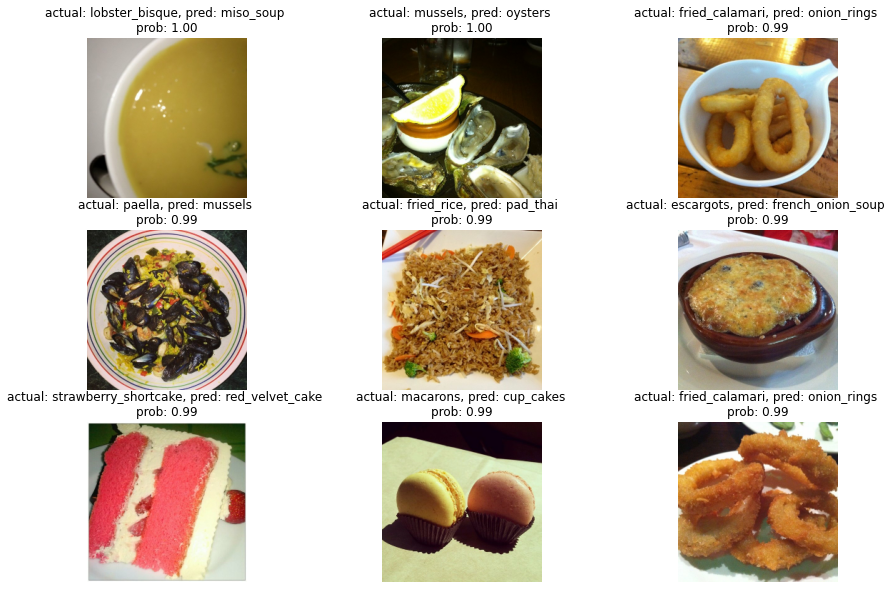

In [88]:
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

In [90]:
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/hamburger.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/pizza-dad.jpeg']

1/1 [==============================] - 0s 56ms/step


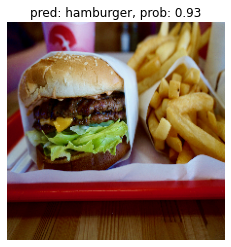

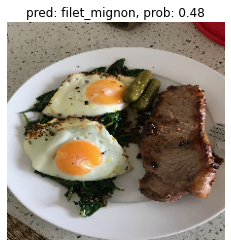

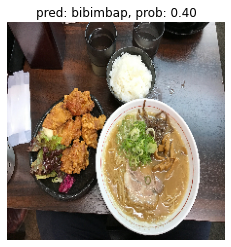

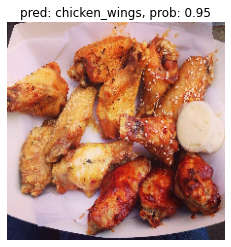

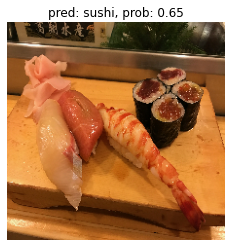

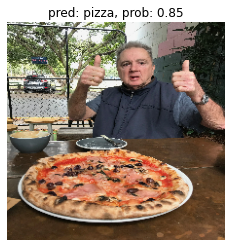

In [91]:
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) 
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) 
  pred_class = class_names[pred_prob.argmax()] 
 
  plt.figure()
  plt.imshow(img/255.) 
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)